# Example notebook for debugging your compression algorithm

This notebook shows how to import the functions from the `competition` folder, in case you want to debug using a notebook.
Remember that any code used in your entry needs to be in the `competition` folder, we will not run this notebook!

See the `README.md` for a description of how we will run your code.

In [5]:
# import your code
from encoder import encode, header_bits
from decoder import decode
from simple_lbt_functions import *
from jteg import *
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math


40957
256.0 0.0
18.447332971675234


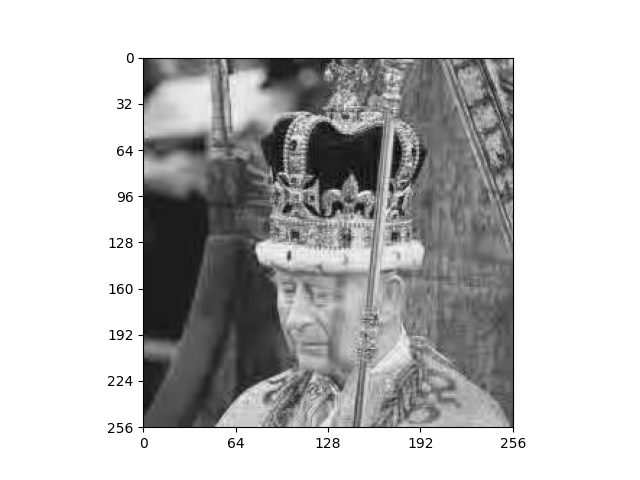

In [6]:
# load in the image
#X, _ = load_mat_img('lighthouse.mat', img_info='X')
#X, _ = load_mat_img('bridge.mat', img_info='X')
#X, _ = load_mat_img('flamingo.mat', img_info='X')
X, _ = load_mat_img('SF2_competition_image_2023.mat', img_info='X')


#print(X[:10,:10])
#X = X + 128.0  # We need to subtract 128.0 first for the processes. 

# CHANGED IMAGE LOADING
#X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
#print(X[:10,:10])
#X = X - 128.0

# encode
vlc, header = encode(X, s=1.6099190603156157)

# Check bitcount
print(vlc[:,1].sum() +1424 + 24)

# check your bitcounting function on the header
header_bits(header)

Z = decode(vlc, header)
print(np.max(Z), np.min(Z))
#print(Z[::12,::12].astype(int))


fig, ax = plt.subplots()
plot_image(Z, ax=ax)

print(np.std(Z-X))

# Required Bit Count

In [7]:
vlc, header = encode(X)
print(vlc[:,1].sum())

39509


In [8]:
"""

required_bits = 40960 - 1424
def objective(quant_size):
    vlc, hufftab = lbtenc(X-128.0, quant_size, opthuff=True, log=False, s = 1)
    bits = vlc[:,1].sum()
    if bits > required_bits:
        return np.abs(bits - required_bits)*10 # Soft penalty, preserving the gradient
    else:
        return np.abs(bits - required_bits)
    
from scipy.optimize import minimize
result = minimize(objective, 128, method='Nelder-Mead')

quant_size_final = result.x[0]
print(quant_size_final)

vlc, hufftab = lbtenc(X-128.0, quant_size_final, opthuff=True, log=False, s = 1)
print(vlc[:,1].sum())

Z = decode(vlc, hufftab)
print(np.std(Z-X))

"""

"\n\nrequired_bits = 40960 - 1424\ndef objective(quant_size):\n    vlc, hufftab = lbtenc(X-128.0, quant_size, opthuff=True, log=False, s = 1)\n    bits = vlc[:,1].sum()\n    if bits > required_bits:\n        return np.abs(bits - required_bits)*10 # Soft penalty, preserving the gradient\n    else:\n        return np.abs(bits - required_bits)\n    \nfrom scipy.optimize import minimize\nresult = minimize(objective, 128, method='Nelder-Mead')\n\nquant_size_final = result.x[0]\nprint(quant_size_final)\n\nvlc, hufftab = lbtenc(X-128.0, quant_size_final, opthuff=True, log=False, s = 1)\nprint(vlc[:,1].sum())\n\nZ = decode(vlc, hufftab)\nprint(np.std(Z-X))\n\n"

[85020, 24209, 14703, 11538]


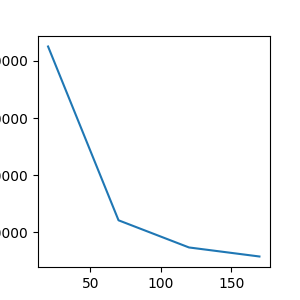

In [9]:
myList = []
quant_size_list = range(20,200,50)

for quant_size in quant_size_list:
    vlc, hufftab = lbtenc(X-128.0, quant_size, opthuff=True, log=False, s = 1.31)
    #vlc, hufftab = encode(X, quant_size, s=1.31)
    bits = vlc[:,1].sum()
    myList.append(bits)
print(myList)

fig, ax = plt.subplots(figsize = (3,3))
ax.plot(quant_size_list,myList)


# Competition optimization here:

Bit count: 40957
RMS: 20.616246422865043
Final quant size: 44.059


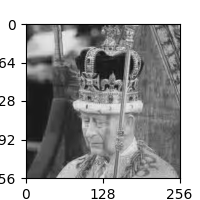

In [10]:
from scipy.optimize import minimize_scalar

def compress_to_bit(X, required_bits = 40960-1424, s=1.31):
    def objective(quant_size):
        #vlc, _ = encode(X, quant_size, s=s)
        vlc, _ = lbtenc(X-128.0, quant_size, opthuff=True, log=False, s = s)
        bits = vlc[:, 1].sum()
        #return abs(bits - required_bits)
        if bits > required_bits:
            return np.abs(bits - (required_bits))**2 * 10  # Soft penalty, preserving the gradient
            #f = np.abs(bits-required_bits)
            #p = 0.001
            #B = 1 / np.abs(bits-required_bits) + (bits > required_bits)*20 # Barrier Function
            #return f - p / B
        else:
            return np.abs(bits - required_bits)

    result = minimize_scalar(objective, bounds=(5, 500), method='bounded')
    quant_size_final = math.ceil(result.x * 1000) / 1000  # Round up to 3 decimal places
    #quant_size_final = result.x
    vlc, hufftab = lbtenc(X-128.0, quant_size_final, opthuff=True, log=False, s = s)
    return vlc, hufftab, quant_size_final

required_bits = 40960 - 1424 - 8 - 16

vlc, hufftab, quant_size_final = compress_to_bit(X, required_bits, s=1.31)
print(f"Bit count: {vlc[:,1].sum()+1424+8+16}")
Z = decode(vlc, hufftab, jpeg_quant_size=quant_size_final)
print(f"RMS: {np.std(Z - X)}")
print(f"Final quant size: {quant_size_final}")

fig, ax = plt.subplots(figsize=(2,2))
plot_image(Z, ax=ax)

[22.20258206856633, 21.73161876404183, 20.61952495286748, 20.768403744354124, 19.58868161630926]


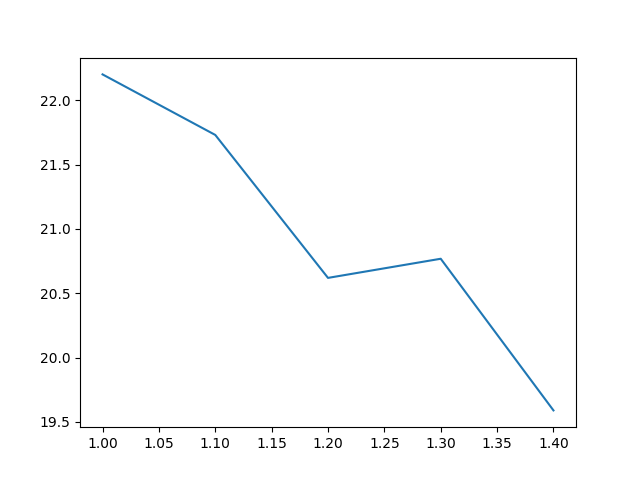

In [11]:
rms_list = []
s_list = np.arange(1,1.5,0.1)

for s in s_list:
    vlc, hufftab, quant_size_final = compress_to_bit(X, required_bits, s=s)
    Z = decode(vlc, hufftab)
    rms = np.std(X-Z)
    rms_list.append(rms)
print(rms_list)

fig, ax = plt.subplots()
ax.plot(s_list,rms_list)


[21.978056339172625, 21.555672918826055, 21.562492726726983, 21.724177356649417, 21.73161876404183, 21.449570510494336, 21.46438756632312, 20.970719982236563, 21.036459821331828]


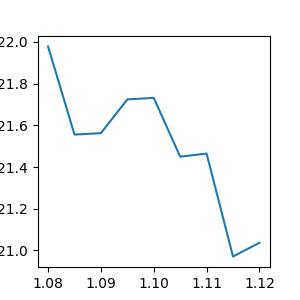

In [12]:

rms_list = []
s_list = np.arange(1.08,1.12,0.005)

for s in s_list:
    vlc, hufftab, quant_size_final = compress_to_bit(X, required_bits, s=s)
    Z = decode(vlc, hufftab)
    rms = np.std(X-Z)
    rms_list.append(rms)
print(rms_list)

fig, ax = plt.subplots(figsize = (3,3))
ax.plot(s_list,rms_list)


In [13]:
"""
# FAILED optimize for N

from scipy.optimize import minimize_scalar

def compress_to_bit_for_N(X, required_bits=40960, s=1.31, N=8):
    def objective(quant_size, N=N):
        #vlc, _ = encode(X, quant_size, s=s)
        vlc, _ = lbtenc(X-128.0, quant_size, N=N, M=N, opthuff=True, s=s, log=False)
        bits = vlc[:, 1].sum()
        #return abs(bits - required_bits)
        if bits > required_bits:
            return np.abs(bits - (required_bits))**2 * 10  # Soft penalty, preserving the gradient
            #f = np.abs(bits-required_bits)
            #p = 0.001
            #B = 1 / np.abs(bits-required_bits) + (bits > required_bits)*20 # Barrier Function
            #return f - p / B
        else:
            return np.abs(bits - required_bits)

    result = minimize_scalar(objective, bounds=(5, 500), method='bounded')
    quant_size_final = math.ceil(result.x * 1000) / 1000  # Round up to 3 decimal places
    #vlc, hufftab = encode(X, quant_size_final, s=s)
    vlc, hufftab = lbtenc(X-128.0, quant_size, N=N, M=N, opthuff=True, s=s, log=False)
    return vlc, hufftab, quant_size_final

required_bits = 40960 - 1424

for N in [4,8,16]:
    print(f"N = {N}")
    vlc, hufftab, quant_size_final = compress_to_bit_for_N(X, required_bits, s=1.31, N=N)
    print(f"Bit count: {vlc[:,1].sum()+1424}")
    #Z = decode(vlc, hufftab)
    Z = lbtdec(vlc, quant_size_final, hufftab=hufftab, log=False, s=1.31, N=N, M=N)
    print(f"RMS: {np.std(Z - X)}")
    print(f"Final quant size: {quant_size_final}")

    fig, ax = plt.subplots(figsize=(2,2))
    plot_image(Z, ax=ax)
"""

'\n# FAILED optimize for N\n\nfrom scipy.optimize import minimize_scalar\n\ndef compress_to_bit_for_N(X, required_bits=40960, s=1.31, N=8):\n    def objective(quant_size, N=N):\n        #vlc, _ = encode(X, quant_size, s=s)\n        vlc, _ = lbtenc(X-128.0, quant_size, N=N, M=N, opthuff=True, s=s, log=False)\n        bits = vlc[:, 1].sum()\n        #return abs(bits - required_bits)\n        if bits > required_bits:\n            return np.abs(bits - (required_bits))**2 * 10  # Soft penalty, preserving the gradient\n            #f = np.abs(bits-required_bits)\n            #p = 0.001\n            #B = 1 / np.abs(bits-required_bits) + (bits > required_bits)*20 # Barrier Function\n            #return f - p / B\n        else:\n            return np.abs(bits - required_bits)\n\n    result = minimize_scalar(objective, bounds=(5, 500), method=\'bounded\')\n    quant_size_final = math.ceil(result.x * 1000) / 1000  # Round up to 3 decimal places\n    #vlc, hufftab = encode(X, quant_size_final, s=s